In [1]:
#initialize packages 


import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.model_selection import GridSearchCV


In [2]:
#load data 

data = pd.read_csv("modeldata_final1.csv")


# Split the data into input features (X) and target variable (y)
X = data.drop('Activity', axis=1)  # Input features
X = X.iloc[:, 2:]
#X = X.drop("Unnamed: 24", axis=1)
#X = X.drop("human", axis = 1)
#X= X[:10000]
y = data['Activity'] # Target variable

feature_names = X.columns.values.tolist()
print(feature_names)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9)

print(X)


['void--ego-vehicle', 'object--vehicle--bus', 'object--traffic-light--general-upright-back', 'marking--discrete--stop-line', 'information--general-directions--g1', 'marking--discrete--arrow--left', 'marking--discrete--symbol--bicycle', 'object--banner', 'object--traffic-light--pedestrians-side', 'object--traffic-light--pedestrians-front', 'object--traffic-light--general-upright', 'object--traffic-light--general-upright-side', 'object--catch-basin', 'construction--flat--traffic-island', 'object--vehicle--truck', 'regulatory--keep-right--g1', 'construction--flat--driveway', 'regulatory--no-stopping--g1', 'marking--discrete--other-marking', 'construction--flat--bike-lane', 'construction--barrier--wall', 'object--traffic-sign--direction-front', 'object--junction-box', 'void--ground', 'object--traffic-light--general-upright-front', 'human--rider--bicyclist', 'marking--continuous--solid', 'marking--discrete--crosswalk-zebra', 'object--wire-group', 'object--manhole', 'object--trash-can', 'obj

# Random grid search 

In [3]:
rfc = RandomForestClassifier(random_state=42)
print(rfc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [4]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 60)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 60)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True]

max_samples = [0.4,0.5,0.6,0.7,0.8]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'max_samples': max_samples}
print(random_grid)

{'n_estimators': [10, 16, 23, 29, 36, 43, 49, 56, 62, 69, 76, 82, 89, 95, 102, 109, 115, 122, 128, 135, 142, 148, 155, 162, 168, 175, 181, 188, 195, 201, 208, 214, 221, 228, 234, 241, 247, 254, 261, 267, 274, 281, 287, 294, 300, 307, 314, 320, 327, 333, 340, 347, 353, 360, 366, 373, 380, 386, 393, 400], 'max_features': ['sqrt'], 'max_depth': [10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 34, 35, 37, 38, 40, 42, 43, 45, 46, 48, 49, 51, 52, 54, 55, 57, 58, 60, 61, 63, 64, 66, 67, 69, 71, 72, 74, 75, 77, 78, 80, 81, 83, 84, 86, 87, 89, 90, 92, 93, 95, 96, 98, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True], 'max_samples': [0.4, 0.5, 0.6, 0.7, 0.8]}


In [5]:

#https://www.kaggle.com/code/prashant111/random-forest-classifier-feature-importance
#https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

#Initialize the model 

rfc = RandomForestClassifier(random_state=42)
k = 5

#Initialize the randomizedSeachCV using the parameter grid and model 
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 300, cv = k, verbose=0, random_state=42, n_jobs = -1)

X_train_val = X_train + X_valid
y_train_val = y_train + y_valid

# Fit the random search model
rfc_random.fit(X_train, y_train)

best_iteration_indices = []
parameters_for_grid = {'n_estimators': [],
               'max_features': [],
               'max_depth': [],
               'min_samples_split': [],
               'min_samples_leaf': [],
               'bootstrap': [],
                'max_samples': []}

#print(rfc_random.cv_results_) 
for i in range(0,k):
    print(f"Fold {i+1}:")
    best_value = np.argmax(rfc_random.cv_results_[f"split{i}_test_score"])
    best_iteration_indices.append(best_value)
    best_accuracy = rfc_random.cv_results_[f"split{i}_test_score"][best_value]
    best_params = rfc_random.cv_results_['params'][best_value]
    for key in best_params:
        if best_params[key] not in parameters_for_grid[key]:
            parameters_for_grid[key].append(best_params[key])
    #mean_accuracy = rfc_random.cv_results_['mean_test_score'][best_value]
    print(f"Best Accuracy in fold {i+1}:", best_accuracy)
    print("Best Parameter:", best_params)
    print("Indices for best accuracy in fold:", best_value)
    #print(f"Mean Accuracy in fold {i+1}:", mean_accuracy)
    print()


mean_test_rand = []    
for i in best_iteration_indices:
    mean_accuracy = rfc_random.cv_results_["mean_test_score"][i]
    mean_test_rand.append(mean_accuracy)
    print(f"Mean test score across folds for candidate {i}:", mean_accuracy)
    
print(best_iteration_indices)
#print(rfc_random.cv_results_)    
#Predict and confusion matrix    
    
pred = rfc_random.predict(X_test)

accuracy_score(y_test,pred)

print(confusion_matrix(y_test,pred))



Fold 1:
Best Accuracy in fold 1: 0.49907635467980294
Best Parameter: {'n_estimators': 168, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.6, 'max_features': 'sqrt', 'max_depth': 61, 'bootstrap': True}
Indices for best accuracy in fold: 200

Fold 2:
Best Accuracy in fold 2: 0.4810594394825993
Best Parameter: {'n_estimators': 29, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.4, 'max_features': 'sqrt', 'max_depth': 38, 'bootstrap': True}
Indices for best accuracy in fold: 202

Fold 3:
Best Accuracy in fold 3: 0.49430243301509086
Best Parameter: {'n_estimators': 294, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': 35, 'bootstrap': True}
Indices for best accuracy in fold: 228

Fold 4:
Best Accuracy in fold 4: 0.49430243301509086
Best Parameter: {'n_estimators': 373, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.4, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': True}
Indices f

In [6]:
print(parameters_for_grid['n_estimators'])
n_estimaters_grid = []
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 0)))
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 0.25)))
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 0.5)))
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 0.75)))
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 1)))


max_depth_grid = []
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 0)))
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 0.25)))
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 0.5)))
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 0.75)))
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 1)))


print(max_depth_grid)

[168, 29, 294, 373, 221]
[14, 30, 36, 44, 61]


# Grid search 

In [7]:
# Create the parameter grid based on the results of random search 

grid_grid = {
    'bootstrap': parameters_for_grid['bootstrap'],
    'max_depth': parameters_for_grid['max_depth'],
    'max_features': ['sqrt'],
    'min_samples_leaf': parameters_for_grid['min_samples_leaf'],
    'min_samples_split': parameters_for_grid['min_samples_split'],
    'n_estimators': parameters_for_grid['n_estimators'],
    'max_samples': parameters_for_grid['max_samples']
}
print(grid_grid)

rfc = RandomForestClassifier(random_state=42)
k = 5 

rfc_grid = GridSearchCV(estimator = rfc, param_grid = grid_grid, 
                          cv = k, n_jobs = -1, verbose = 0)

rfc_grid.fit(X_train, y_train)

best_iteration_indices_grid = []

 
for i in range(0,k):
    print(f"Fold {i+1}:")
    best_value = np.argmax(rfc_grid.cv_results_[f"split{i}_test_score"])
    best_iteration_indices_grid.append(best_value)
    best_accuracy = rfc_grid.cv_results_[f"split{i}_test_score"][best_value]
    best_params = rfc_grid.cv_results_['params'][best_value]
    #mean_accuracy = rfc_random.cv_results_['mean_test_score'][best_value]
    print(f"Best Accuracy in fold {i+1}:", best_accuracy)
    print("Best Parameter:", best_params)
    print("Indices for best accuracy in fold:", best_value)
    #print(f"Mean Accuracy in fold {i+1}:", mean_accuracy)

print(best_iteration_indices_grid)

mean_test_grid = []
for i in best_iteration_indices_grid:
    mean_accuracy = rfc_grid.cv_results_["mean_test_score"][i]
    mean_test_grid.append(mean_accuracy)
    print(f"Mean test score across folds for candidate {i}:", mean_accuracy)
    

    
pred_grid = rfc_grid.predict(X_test)

accuracy_score(y_test,pred)

print(confusion_matrix(y_test,pred_grid))


print(5*(len(parameters_for_grid['bootstrap'])*len(parameters_for_grid['max_depth'])*len(parameters_for_grid['min_samples_leaf'])*len(parameters_for_grid['min_samples_split'])*len(parameters_for_grid['n_estimators'])*len(parameters_for_grid['max_samples'])))


{'bootstrap': [True], 'max_depth': [61, 38, 35, 14], 'max_features': ['sqrt'], 'min_samples_leaf': [4, 1], 'min_samples_split': [10, 2], 'n_estimators': [168, 29, 294, 373, 221], 'max_samples': [0.6, 0.4, 0.5]}
Fold 1:
Best Accuracy in fold 1: 0.49907635467980294
Best Parameter: {'bootstrap': True, 'max_depth': 61, 'max_features': 'sqrt', 'max_samples': 0.6, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 168}
Indices for best accuracy in fold: 0
Fold 2:
Best Accuracy in fold 2: 0.4810594394825993
Best Parameter: {'bootstrap': True, 'max_depth': 61, 'max_features': 'sqrt', 'max_samples': 0.4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 29}
Indices for best accuracy in fold: 26
Fold 3:
Best Accuracy in fold 3: 0.49430243301509086
Best Parameter: {'bootstrap': True, 'max_depth': 35, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 294}
Indices for best accuracy in fold: 167
Fold 4:
Best Accuracy 

# Model 

Test set accuracy: 0.4953436807095344
Out of bag score 0.484910076373491
Out of bag decision function [[0.31933903 0.4175587  0.26310227]
 [0.22703822 0.35999922 0.41296256]
 [0.14477677 0.33475399 0.52046924]
 ...
 [0.46565253 0.35195532 0.18239215]
 [0.39332947 0.33800581 0.26866472]
 [0.18881715 0.44773135 0.3634515 ]]
16236
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 35, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 294, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}
Confusion matrix random search: 
 [[890 263 327]
 [566 403 525]
 [361 234 941]]
Model feature importances: [0.053125603905789916, 0.05058710199368116, 0.04014237100341845, 0.038409894418627244, 0.035554464007327424, 0.03450711087692842, 0.032468308562623414, 0.031191773872152388, 

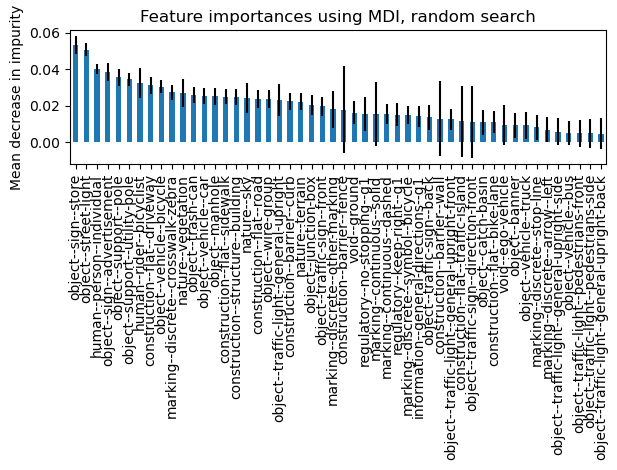

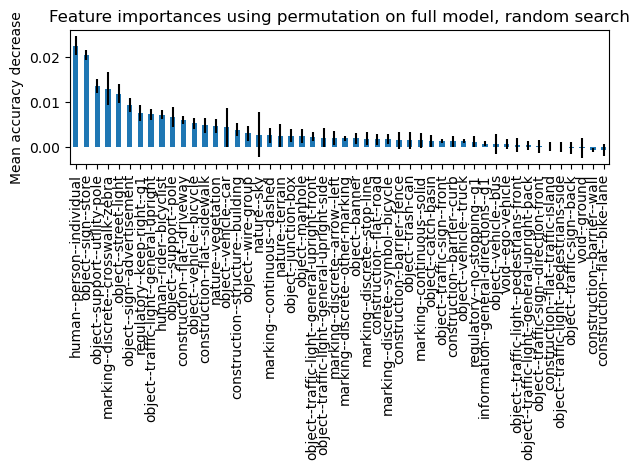

human--person--individual     0.023 +/- 0.005
object--sign--store           0.021 +/- 0.004
object--support--utility-pole 0.014 +/- 0.002
marking--discrete--crosswalk-zebra0.013 +/- 0.004
object--street-light          0.012 +/- 0.003
object--sign--advertisement   0.009 +/- 0.002
regulatory--keep-right--g1    0.008 +/- 0.001
object--traffic-light--general-upright0.007 +/- 0.002
human--rider--bicyclist       0.007 +/- 0.002
object--support--pole         0.007 +/- 0.001
construction--flat--driveway  0.006 +/- 0.001
object--vehicle--bicycle      0.005 +/- 0.002
construction--flat--sidewalk  0.005 +/- 0.001
nature--vegetation            0.005 +/- 0.001
object--vehicle--car          0.004 +/- 0.002
construction--structure--building0.004 +/- 0.002
object--wire-group            0.003 +/- 0.001
marking--continuous--dashed   0.003 +/- 0.001
object--traffic-light--general-upright-side0.002 +/- 0.000
object--banner                0.002 +/- 0.001


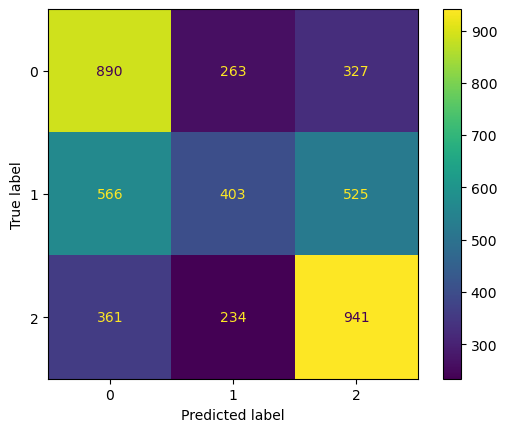

In [8]:
#split data

#define parameters

#random 

best_test = np.argmax(mean_test_rand)
best_test_i = best_iteration_indices[best_test]
best_param = rfc_random.cv_results_['params'][best_test_i]

model_rand = RandomForestClassifier(**best_param,oob_score=True)
model_rand.fit(X_train, y_train)

y_pred_rand = model_rand.predict(X_test)

# Evaluate the model's performance on the test set
accuracy_rand = accuracy_score(y_test, y_pred_rand)
print("Test set accuracy:", accuracy_rand)
print("Out of bag score", model_rand.oob_score_)
print("Out of bag decision function", model_rand.oob_decision_function_)
print(len(model_rand.oob_decision_function_))
print(model_rand.get_params())

print("Confusion matrix random search: \n",  confusion_matrix(y_test,y_pred_rand))


print("Model feature importances:", sorted(model_rand.feature_importances_,reverse=True))
print("Model feature importances names:", [model_rand.feature_names_in_[i] for i in sorted(range(len(model_rand.feature_importances_)), key=lambda k: model_rand.feature_importances_[k], reverse=True)])


importances = model_rand.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rand.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
sorted_importances = forest_importances.sort_values(ascending=False)  # Sorting the importances

sorted_feature_names = sorted_importances.index  # Sorting the feature names based on importances

fig, ax = plt.subplots()
sorted_importances.plot.bar(yerr=std[sorted_importances.index.get_indexer(sorted_feature_names)], ax=ax)  # Using sorted importances and corresponding std
ax.set_title("Feature importances using MDI, random search")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


from sklearn.inspection import permutation_importance

result = permutation_importance(
    model_rand, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances_perm = pd.Series(result.importances_mean, index=feature_names)

sorted_importances_perm = forest_importances_perm.sort_values(ascending=False)  # Sorting the importances

sorted_feature_names_perm = forest_importances_perm.index  # Sorting the feature names based on importances


#print(result)    
fig, ax = plt.subplots()
sorted_importances_perm.plot.bar(yerr=result.importances_std[sorted_importances_perm.index.get_indexer(sorted_feature_names_perm)], ax=ax)
ax.set_title("Feature importances using permutation on full model, random search")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()



for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{feature_names[i]:<30}"
               f"{result.importances_mean[i]:.3f}"
              f" +/- {result.importances_std[i]:.3f}")
        
cm_rand = confusion_matrix(y_test, y_pred_rand, labels=model_rand.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rand,display_labels=model_rand.classes_)
disp.plot()
plt.show()

Test set accuracy: 0.4893569844789357
Out of bag score 0.4866962305986696
Out of bag decision function [[0.33437949 0.39344509 0.27217543]
 [0.24701923 0.35286666 0.40011411]
 [0.14678878 0.32991408 0.52329714]
 ...
 [0.44359716 0.33745264 0.2189502 ]
 [0.39824693 0.3370532  0.26469987]
 [0.18368176 0.46174923 0.35456902]]
16236
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 294, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}
Confusion matrix gridsearch: 
 [[932 240 308]
 [620 367 507]
 [391 237 908]]
Model feature importances: [0.052815116332328986, 0.039904208829946976, 0.037673573576418914, 0.03737137170635098, 0.03338243315133895, 0.03264192225889732, 0.032457752740676055, 0.03245607486876552, 0.

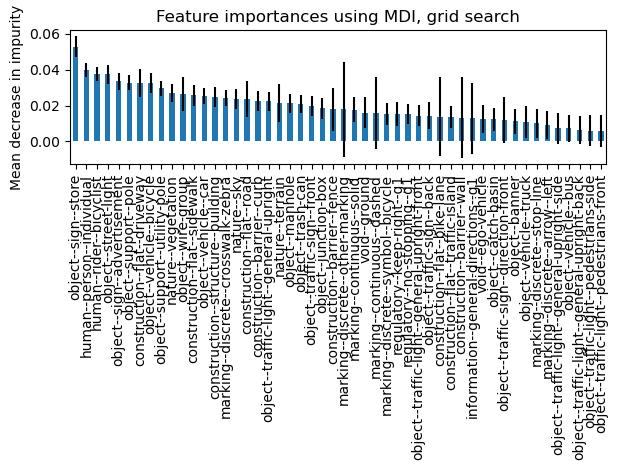

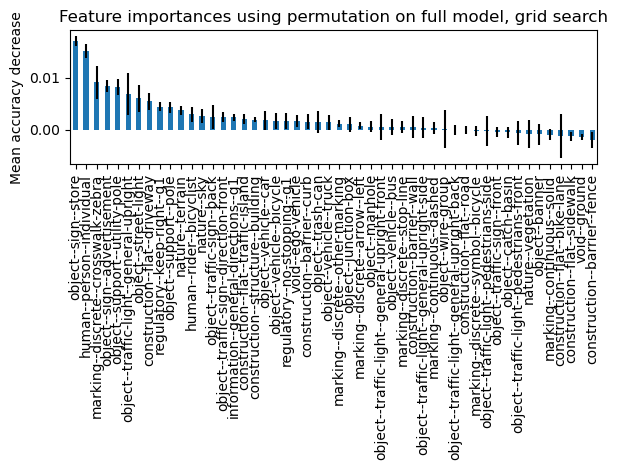

object--sign--store           0.017 +/- 0.003
human--person--individual     0.015 +/- 0.004
marking--discrete--crosswalk-zebra0.009 +/- 0.004
object--sign--advertisement   0.008 +/- 0.003
object--support--utility-pole 0.008 +/- 0.003
object--traffic-light--general-upright0.007 +/- 0.002
construction--flat--driveway  0.005 +/- 0.002
regulatory--keep-right--g1    0.004 +/- 0.002
object--support--pole         0.004 +/- 0.002
nature--terrain               0.004 +/- 0.001
object--traffic-sign--back    0.003 +/- 0.001
object--traffic-sign--direction-front0.002 +/- 0.001
information--general-directions--g10.002 +/- 0.001


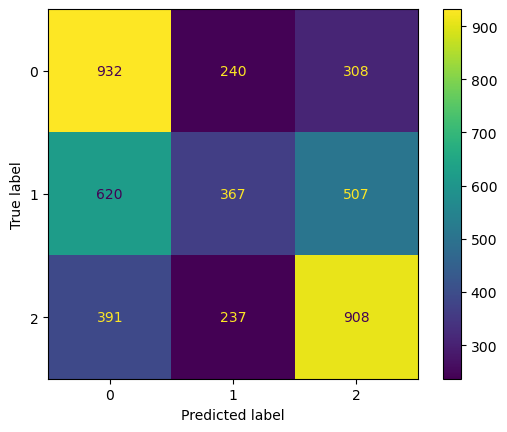

In [9]:
#Grid

best_test = np.argmax(mean_test_grid)
best_test_i = best_iteration_indices_grid[best_test]
best_param_grid = rfc_grid.cv_results_['params'][best_test_i]

model_grid = RandomForestClassifier(**best_param_grid,oob_score=True)
model_grid.fit(X_train, y_train)

y_pred_grid = model_grid.predict(X_test)

# Evaluate the model's performance on the test set
accuracy_grid = accuracy_score(y_test, y_pred_grid)
print("Test set accuracy:", accuracy_grid)
print("Out of bag score", model_grid.oob_score_)
print("Out of bag decision function", model_grid.oob_decision_function_)
print(len(model_grid.oob_decision_function_))
print(model_grid.get_params())

print("Confusion matrix gridsearch: \n", confusion_matrix(y_test,y_pred_grid))

print("Model feature importances:", sorted(model_grid.feature_importances_,reverse=True))
print("Model feature importances names:", [model_grid.feature_names_in_[i] for i in sorted(range(len(model_rand.feature_importances_)), key=lambda k: model_rand.feature_importances_[k], reverse=True)])

importances = model_grid.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_grid.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
sorted_importances = forest_importances.sort_values(ascending=False)  # Sorting the importances

sorted_feature_names = sorted_importances.index  # Sorting the feature names based on importances

fig, ax = plt.subplots()
sorted_importances.plot.bar(yerr=std[sorted_importances.index.get_indexer(sorted_feature_names)], ax=ax)  # Using sorted importances and corresponding std
ax.set_title("Feature importances using MDI, grid search")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


from sklearn.inspection import permutation_importance

result = permutation_importance(
    model_grid, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances_perm = pd.Series(result.importances_mean, index=feature_names)

sorted_importances_perm = forest_importances_perm.sort_values(ascending=False)  # Sorting the importances

sorted_feature_names_perm = forest_importances_perm.index  # Sorting the feature names based on importances


#print(result)    
fig, ax = plt.subplots()
sorted_importances_perm.plot.bar(yerr=result.importances_std[sorted_importances_perm.index.get_indexer(sorted_feature_names_perm)], ax=ax)
ax.set_title("Feature importances using permutation on full model, grid search")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()



for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{feature_names[i]:<30}"
               f"{result.importances_mean[i]:.3f}"
              f" +/- {result.importances_std[i]:.3f}")
        
cm_grid = confusion_matrix(y_test, y_pred_grid, labels=model_grid.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_grid,display_labels=model_grid.classes_)
disp.plot()
plt.show()

In [10]:
## Dummy classifier 
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.score(X, y)

0.3405321507760532